In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from xgboost import XGBClassifier
import shap

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

Dataframe shape: (11055, 31)
Number of 1: 6157
Number of -1: 4898


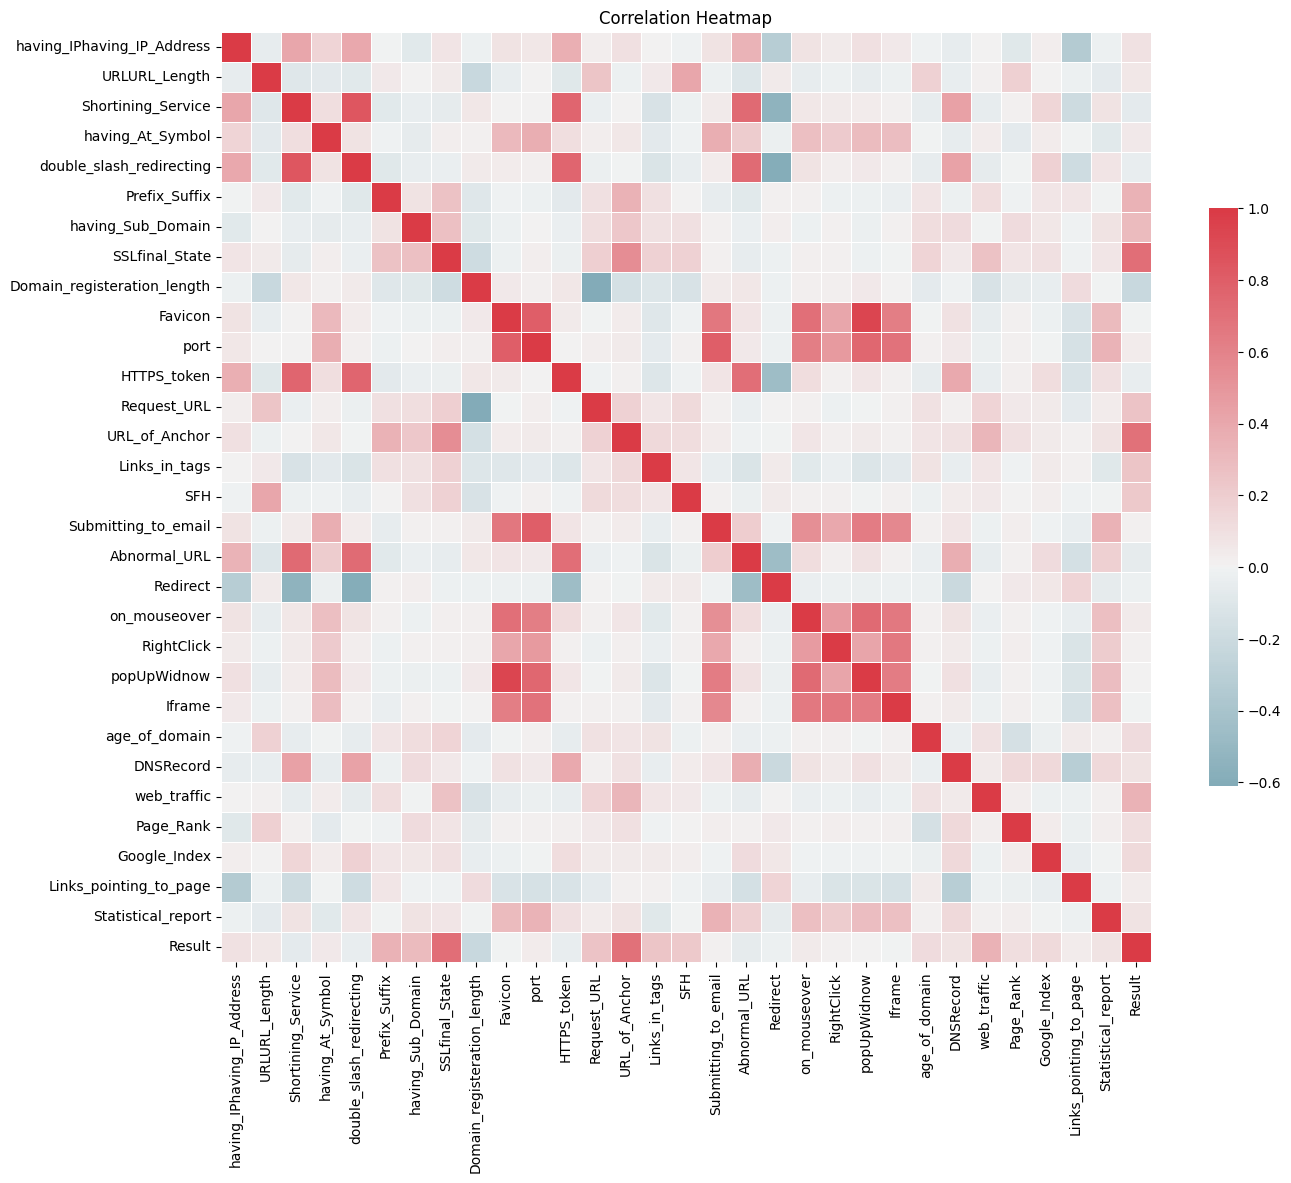

In [ ]:
df = pd.read_csv('/content/dataset.csv', index_col=0)

print(f"Dataframe shape: {df.shape}")

X = df.drop('Result', axis=1)
y = df['Result'].replace(-1, 0)

print("Number of 1:", len(df[df["Result"] == 1]))
print("Number of -1:", len(df[df["Result"] == -1]))

corr = df.corr()

plt.figure(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME', random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss"),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42)
}
# Implementation note¹

Random Forest Accuracy: 0.9670, F1-Score: 0.9712, Precision: 0.9632, Recall: 0.9793
AdaBoost Accuracy: 0.9299, F1-Score: 0.9386, Precision: 0.9338, Recall: 0.9434
XGBoost Accuracy: 0.9706, F1-Score: 0.9744, Precision: 0.9648, Recall: 0.9841
KNN Accuracy: 0.9408, F1-Score: 0.9481, Precision: 0.9432, Recall: 0.9530
SVM Accuracy: 0.9471, F1-Score: 0.9540, Precision: 0.9425, Recall: 0.9657


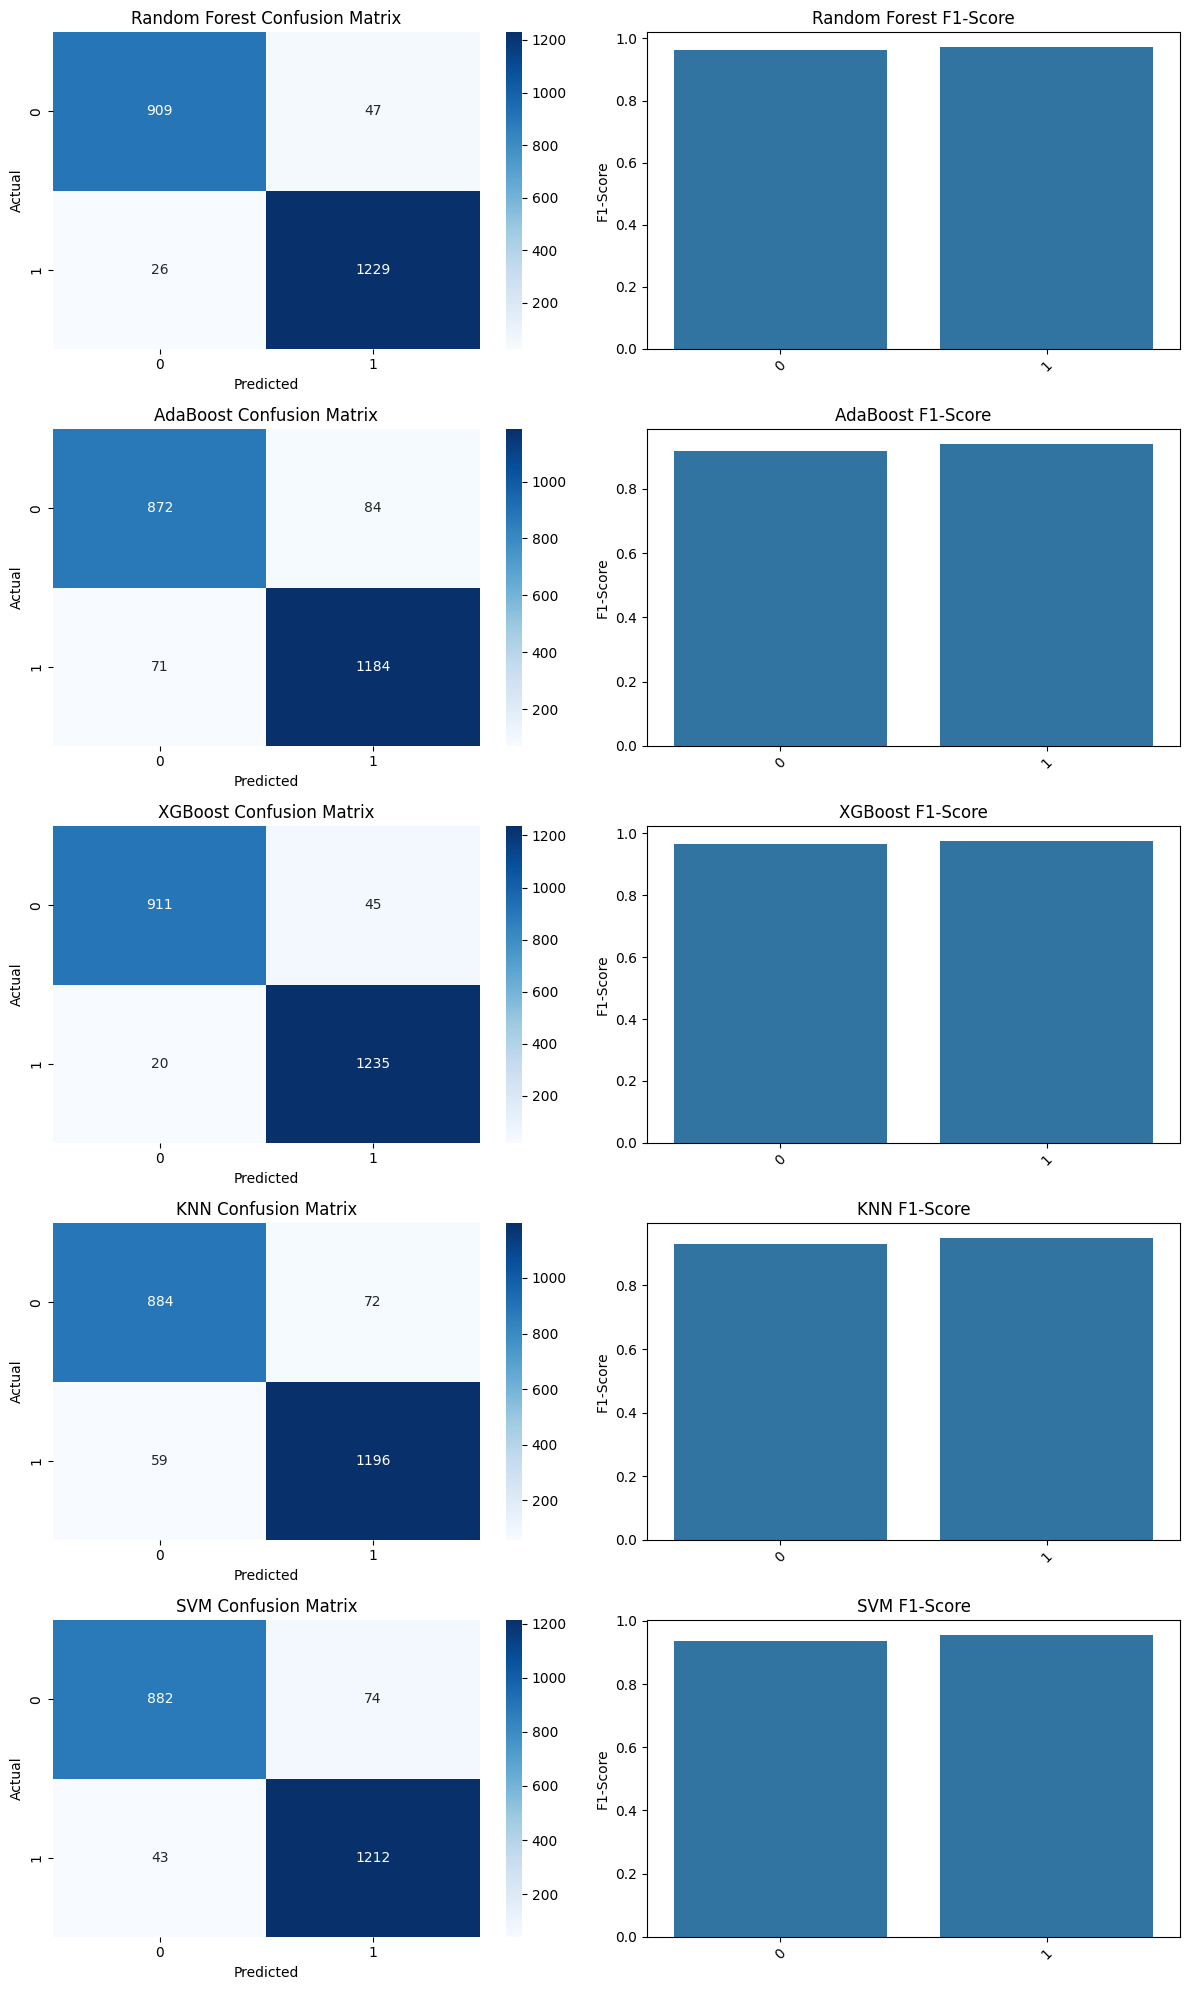

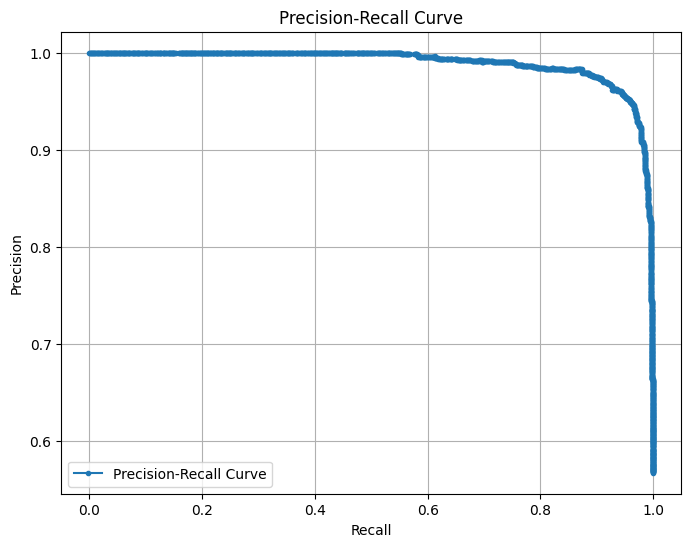

AUC: 0.9862208071479771


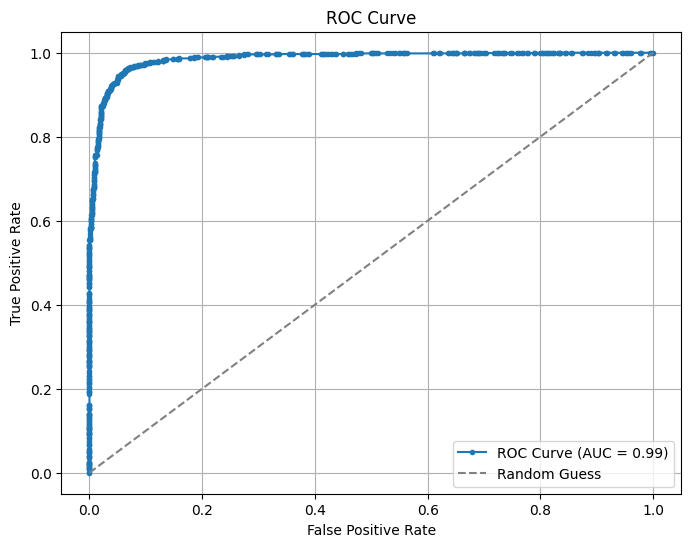

In [ ]:
fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(12, len(models) * 4))
axes = axes.flatten()

metrics_list = []

for i, (model_name, model) in enumerate(models.items()):

    model.fit(X_train, y_train)

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        if hasattr(model, "decision_function"):
            y_pred_proba = model.decision_function(X_test)
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        else:
            y_pred_proba = None

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = report['1']['f1-score']

    metrics_list.append({"Model": model_name, "Accuracy": accuracy, "F1-Score": f1, "Precision": precision, "Recall": recall})
    print(f"{model_name} Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i*2], cmap='Blues')
    axes[i*2].set_title(f'{model_name} Confusion Matrix')
    axes[i*2].set_xlabel('Predicted')
    axes[i*2].set_ylabel('Actual')

    class_labels = list(report.keys())[:-3]
    f1_scores = [report[label]['f1-score'] for label in class_labels]
    sns.barplot(x=class_labels, y=f1_scores, ax=axes[i*2+1])
    axes[i*2+1].set_title(f'{model_name} F1-Score')
    axes[i*2+1].set_ylabel('F1-Score')
    axes[i*2+1].set_xticks(range(len(class_labels)))
    axes[i*2+1].set_xticklabels(class_labels, rotation=45)


plt.tight_layout()
plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_proba)

print("AUC:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7814 - loss: 0.4518 - val_accuracy: 0.9222 - val_loss: 0.1969
Epoch 2/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9204 - loss: 0.2079 - val_accuracy: 0.9326 - val_loss: 0.1698
Epoch 3/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9256 - loss: 0.1869 - val_accuracy: 0.9349 - val_loss: 0.1583
Epoch 4/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9310 - loss: 0.1800 - val_accuracy: 0.9380 - val_loss: 0.1513
Epoch 5/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9387 - loss: 0.1613 - val_accuracy: 0.9435 - val_loss: 0.1402
Epoch 6/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9401 - loss: 0.1457 - val_accuracy: 0.9430 - val_loss: 0.1370
Epoch 7/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9417 - loss: 0.1388 - val_accuracy: 0.9435 - val_loss: 0.1310
Epoch 8/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9486 - loss: 0.1254 - val_accuracy: 0.

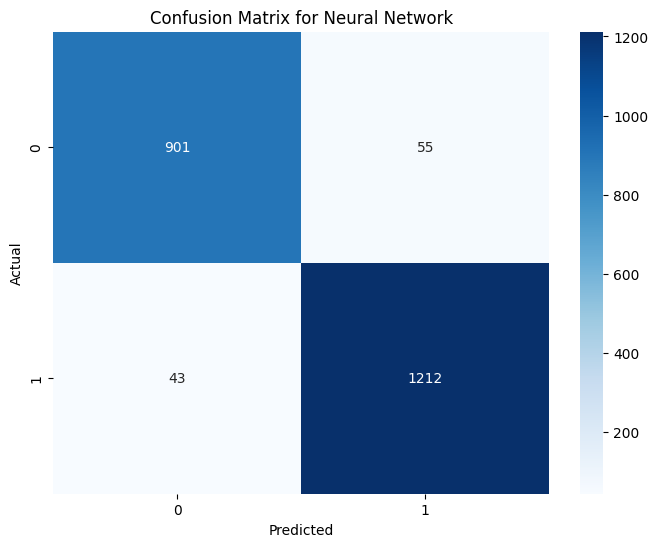


Comparison of Model Metrics:
            Model  Accuracy  F1-Score  Precision    Recall
0   Random Forest  0.966983  0.971158   0.963166  0.979283
1        AdaBoost  0.929896  0.938565   0.933754  0.943426
2         XGBoost  0.970602  0.974359   0.964844  0.984064
3             KNN  0.940751  0.948078   0.943218  0.952988
4             SVM  0.947083  0.953955   0.942457  0.965737
5  Neural Network  0.955676  0.961142   0.956590  0.965737


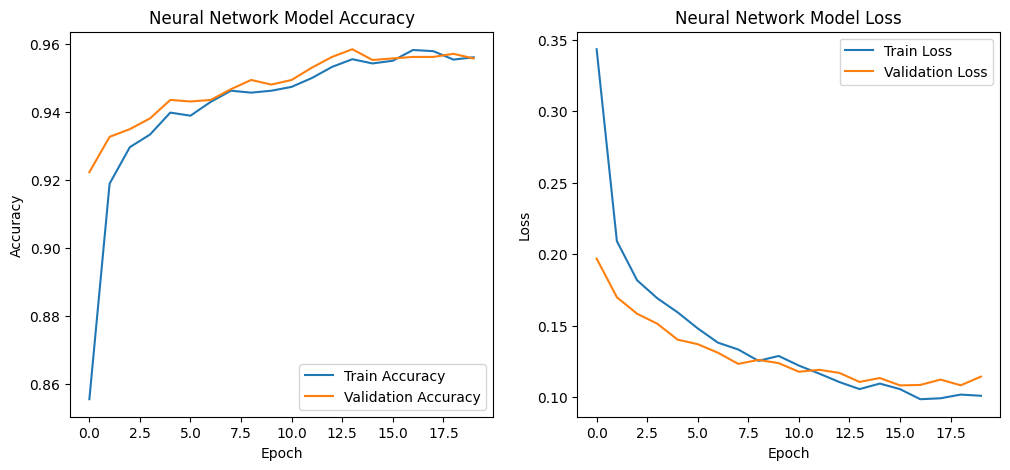

In [ ]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


nn_model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])  # Implementation note²

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = nn_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=20, batch_size=32, verbose=1)

nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")

y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)
nn_precision = precision_score(y_test, y_pred_nn)
nn_recall = recall_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)

print(f"Neural Network Precision: {nn_precision:.4f}")
print(f"Neural Network Recall: {nn_recall:.4f}")
print(f"Neural Network F1-Score: {nn_f1:.4f}")

nn_f1 = f1_score(y_test, y_pred_nn)
print(f"Neural Network F1-Score: {nn_f1:.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


plt.figure(figsize=(12, 5))

comparison_df = pd.DataFrame(metrics_list)

comparison_df = pd.concat([comparison_df, pd.DataFrame([{
    "Model": "Neural Network",
    "Accuracy": nn_accuracy,
    "F1-Score": nn_f1,
    "Precision": nn_precision,
    "Recall": nn_recall
}])], ignore_index=True)

print("\nComparison of Model Metrics:")
print(comparison_df)

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

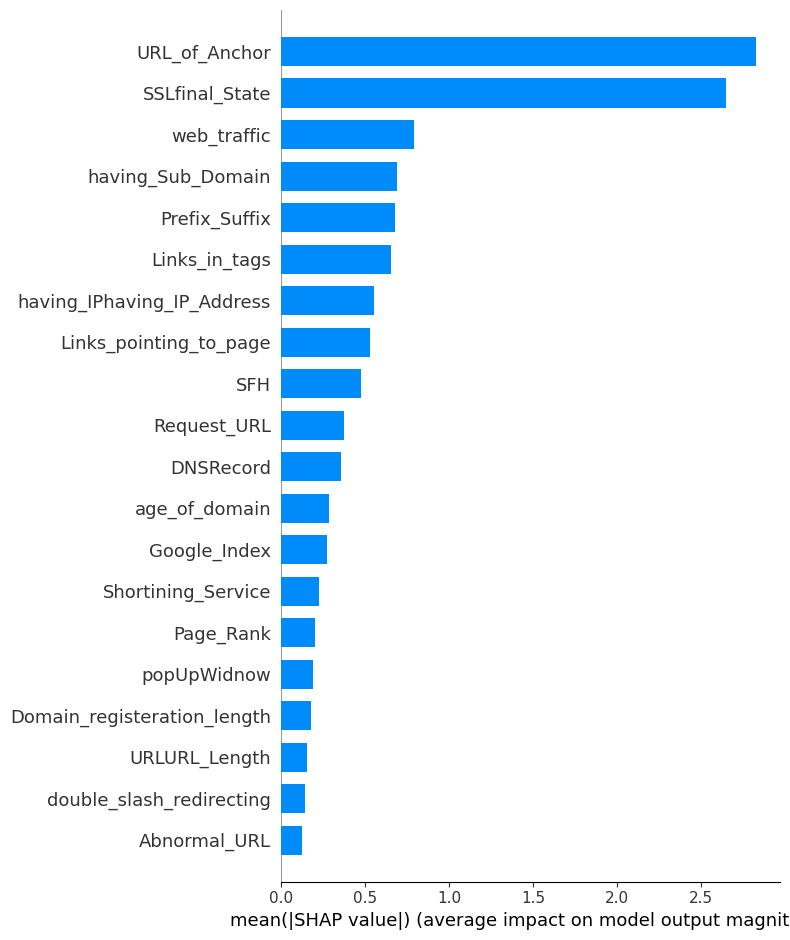

In [ ]:
models["XGBoost"].fit(X_train, y_train)
explainer = shap.TreeExplainer(models["XGBoost"])
shap_values = explainer.shap_values(X_train)

plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar")


In [ ]:
comparison_df = pd.DataFrame(metrics_list)
comparison_df = pd.concat([comparison_df, pd.DataFrame([{"Model": "Neural Network", "Accuracy": nn_accuracy, "F1-Score": nn_f1}])], ignore_index=True)
print("\nComparison of Model Metrics:")
print(comparison_df)



Comparison of Model Metrics:
            Model  Accuracy  F1-Score  Precision    Recall
0   Random Forest  0.966983  0.971158   0.963166  0.979283
1        AdaBoost  0.929896  0.938565   0.933754  0.943426
2         XGBoost  0.970602  0.974359   0.964844  0.984064
3             KNN  0.940751  0.948078   0.943218  0.952988
4             SVM  0.947083  0.953955   0.942457  0.965737
5  Neural Network  0.955676  0.961142        NaN       NaN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Notes:
¹GPT-4, "Machine Learning Model Architecture Design" (San Francisco: OpenAI, 2023), accessed October 30, 2024 https://chat.openai.com
²GPT-4, "Neural Network Implementation" (San Francisco: OpenAI, 2023), accessed October 30, 2024 https://chat.openai.com
"""